#### Laurent Jutras-Dubé   


# Infinite-period scenario of Fig. 7


####     

**1. Pattern formation with the infinite-period scenario**

In this notebook, we study the model of coupled oscillators from the following paper:

Morelli, L. G., Ares, S., Herrgen, L., Schröter, C., Jülicher, F., & Oates, A. C. (2009). Delayed coupling theory of vertebrate segmentation. *HSFP Journal*, 3(1), 55-66.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

####     

**1.1 The frequency of the oscillations**

We first define the function that computes the frequency of the oscillations inside the 1D array of cells as a function of time.

In [2]:
def compute_omega(t, param):
    
    n_cells = param["n_cells"]
    w_inf = param["w_inf"]
    a = param["a"]
    v = param["v"]
    s = param["s"]
    L = param["L"]
    
    positions = np.arange(1, n_cells+1)
    omega = w_inf*(1. -np.exp(-(positions*a -v*t)/s))
    omega[positions < v*t/a] = 0.
    omega[positions >= (L+v*t)/a] = w_inf*(1. -np.exp(-L/s))
    
    return omega

####          

**1.2 The coupling term**

In the next code cell, we define a function that computes the coupling term.

In [3]:
def compute_coupling(t, phi, phi_delay, param):
    
    n_cells = param["n_cells"]
    epsilon = param["epsilon"]
    a = param["a"]
    v = param["v"]
    
    coupling_term = np.zeros(len(phi))
    coupling_term[1:-1] = 0.5*epsilon/a**2*(np.sin(phi_delay[:-2]-phi[1:-1]) +np.sin(phi_delay[2:]-phi[1:-1]))
    
    # Reflective boundary conditions
    coupling_term[0] = epsilon/a**2*np.sin(phi_delay[1]-phi[0])
    coupling_term[-1] = epsilon/a**2*np.sin(phi_delay[-2]-phi[-1])
    
    # Arrested cells
    positions = np.arange(1, n_cells+1)
    coupling_term[positions < v*t/a] = 0.
    
    
    return coupling_term

####    

**1.3 The integration scheme** 

We use the Euler integration scheme to perform the integration of the ODE describing the  model. The `integrate` function takes the dictionary of parameters as an input. The four output matrices, `results`, `g_gradient`, `omega_gradient`, and `times_plot`, respectively contain the phase of the oscillators at all positions for every time point, the spatio-temporal distribution of parameter $g$, the spatio-temporal profile of the frequency of the oscillator and the array of time points. 

In [4]:
def integrate(param):
    
    # Set integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]
    
    n_cells = param["n_cells"]
    phi = np.zeros(n_cells) +param["init_phase"]
    results = [phi]
    
    omega = compute_omega(0., param)
    omega_profile = [omega]
    
    tau = param["tau"]
    coupling_term = np.zeros(n_cells)


    # Perform the integration
    for t in times[1:]:
        
        phi = phi +omega*dt +coupling_term*dt
        omega = compute_omega(t, param)
            
        results.append(phi)
        omega_profile.append(omega)
        
        if (t > tau):
            phi_delay = results[int((t-tau)/dt)]
            coupling_term = compute_coupling(t, phi, phi_delay, param)
        

    # Output the results
    results = np.array(results)
    omega_profile = np.array(omega_profile)
    
    return results, omega_profile, times

####     

**1.4 The dynamics of pattern formation** 

We define all the parameters required for the frequency profile and for the integration scheme.

In [5]:
param = {
    
    # Parameters for the integration
    "total_t"    : 400.,
    "dt"         : 0.01,
    "n_cells"    : 100,
    "init_phase" : 0.,
    
    # Parameters for the omega profile
    "w_inf" : 0.33861,  # characeristic intrinsic frequency
    "a"     : 1.,       # average cell diameter
    "v"     : 0.255,    # velocity of the arrest front
    "s"     : 36,       # decay length of the frequency profile
    "L"     : 39,       # length of the presomitic mesoderm
    
    # Parameters for the coupling term
    "epsilon" : 0.07,   # coupling strength
    "tau"     : 0.      # time delay
}

####       

**1.4.1 No delay in the coupling**

We first consider no delay in the coupling between neighboring cells, as in Fig. 3a) of (Morelli et al., 2009). We use the `integrate` function to perform the integration. We plot the spatio-temporal profile of the cosine of the phase of the oscillators on a kymograph. We also plot the spatio-temporal profile of frequency $\omega$. Finally, we plot the trajectory of a representative cell.

<IPython.core.display.Javascript object>


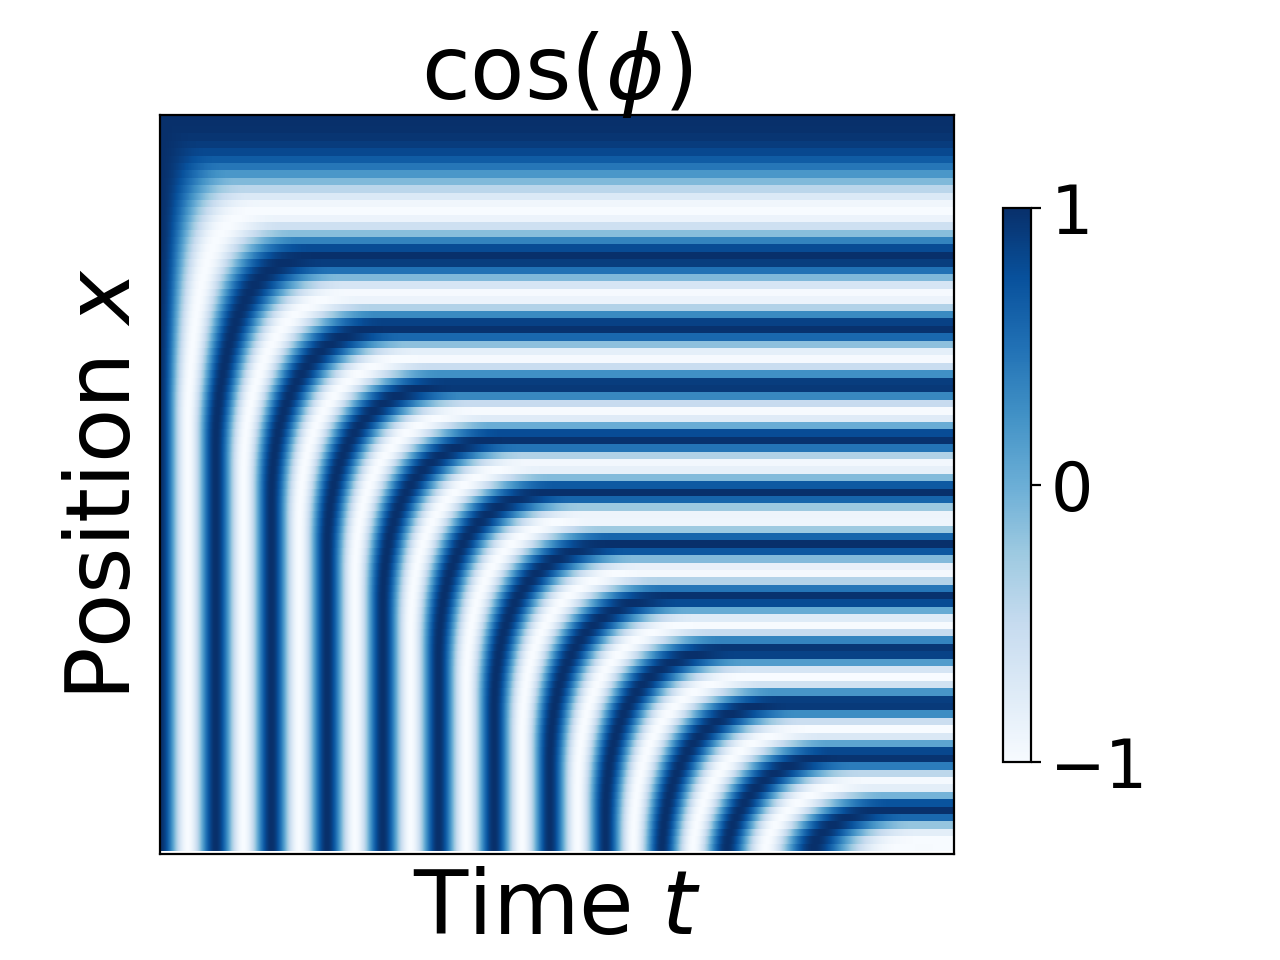

In [6]:
# Generate the results
param["tau"] = 0.
results_no_delay, omega_profile_no_delay, times = integrate(param)


# Plot a kymograph of the results
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
   
# Kymograph
norm = colors.Normalize(vmin=-1., vmax=1.)
kymo = ax.imshow(np.cos(results_no_delay).transpose(), norm=norm, cmap='Blues', aspect='auto')
   
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-1., 0., 1.])
cb.ax.tick_params(labelsize=24)

# Other plot options
ax.set_title('$\cos(\phi)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

<IPython.core.display.Javascript object>


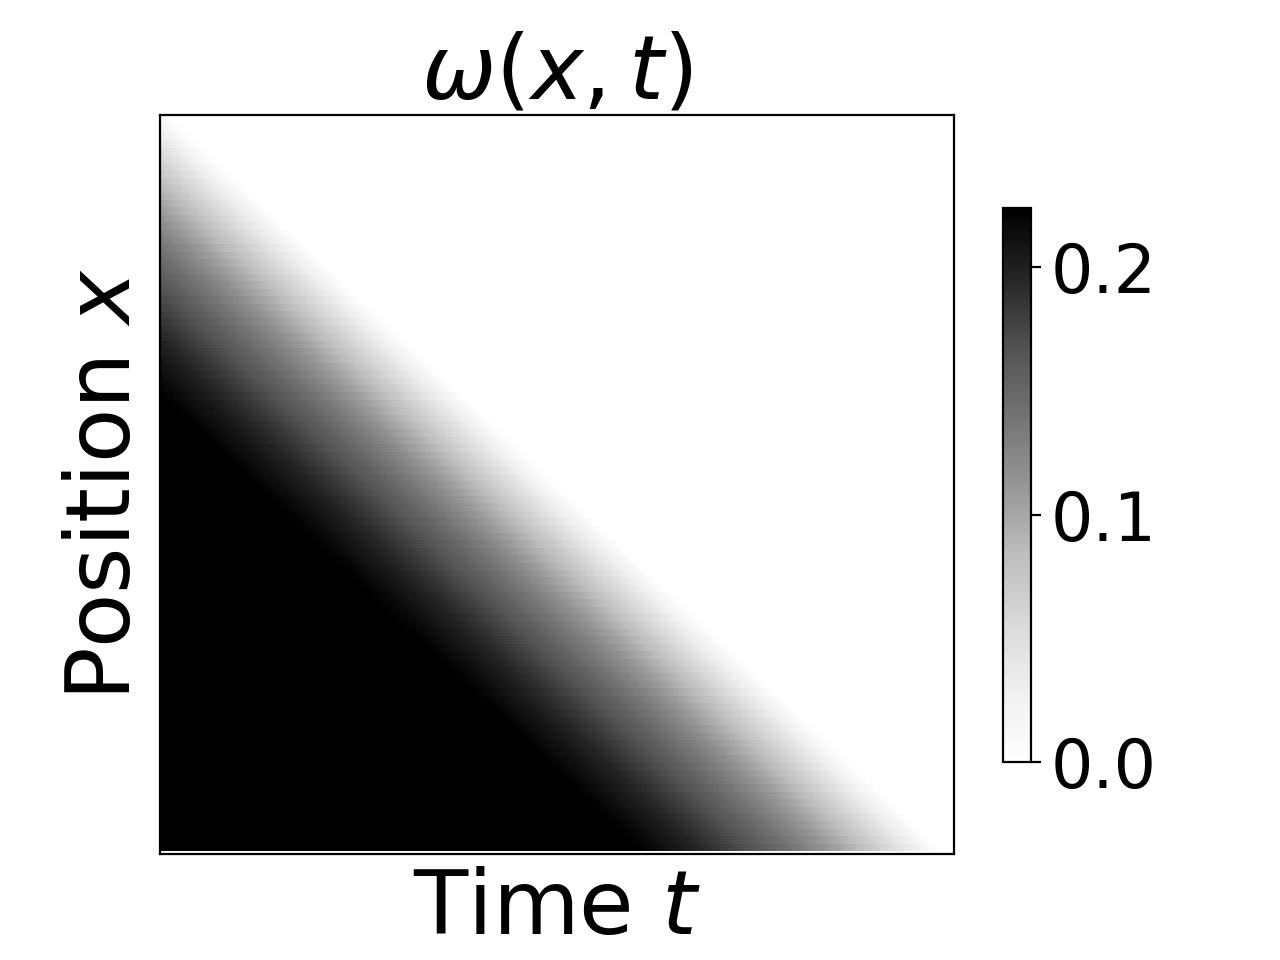

In [7]:
# Generate the kymograph of the frequency
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymgograph
kymo = ax.imshow(omega_profile_no_delay.transpose(), cmap='Greys', aspect='auto') #, norm=norm)
    
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.1, 0.2])
cb.ax.tick_params(labelsize=24)
    
# Other plot options
ax.set_title('$\omega(x,t)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####   

In the next code cells, we plot the spatial wave profile at two different time points.

<IPython.core.display.Javascript object>


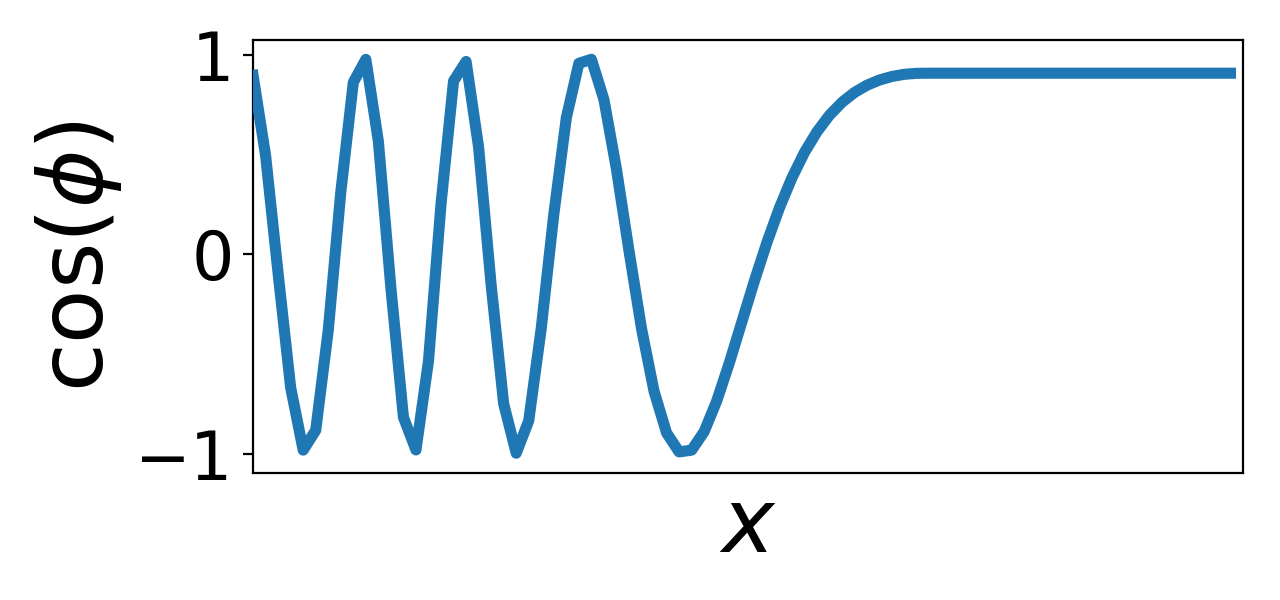

<IPython.core.display.Javascript object>


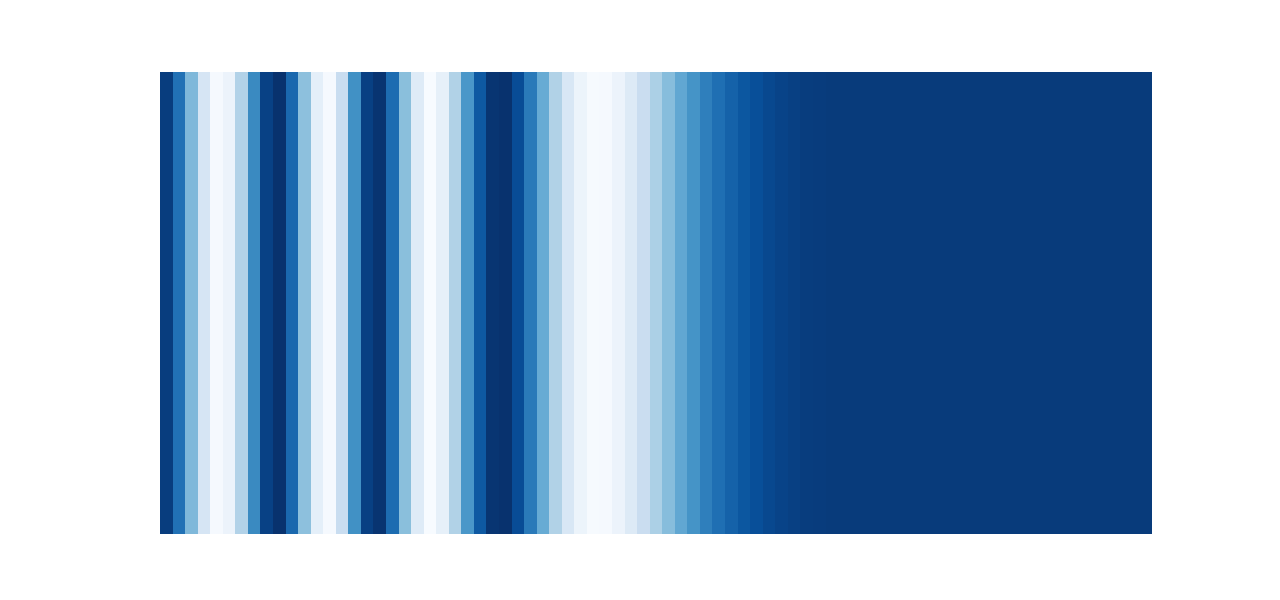

In [8]:
n_cells = param["n_cells"]
positions = np.arange(1, n_cells+1)
t_index = int(param["total_t"]/3./param["dt"])+500
start = 20
end = 99



# 1D y profile
plt.rcParams["figure.figsize"] = 6.4, 3.
fig, ax = plt.subplots()

ax.plot(positions[start:end], np.cos(results_no_delay)[t_index,start:end], c='tab:blue', lw=4, label='cos($\phi$)', zorder=10)

# Plot options
ax.set_xlabel('$x$', fontsize=32)
ax.set_ylabel('cos($\phi$)', fontsize=32)
ax.set_xlim([positions[start], positions[end]])
ax.set_xticks([])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()



# 2D y profile
tissue = np.array([np.cos(results_no_delay)[t_index,start:end] for k in range(50)])
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=-1.0, vmax=1.)
ax.imshow(tissue, norm=norm, cmap='Blues', aspect='auto')  

ax.axis('off')
fig.show()

<IPython.core.display.Javascript object>


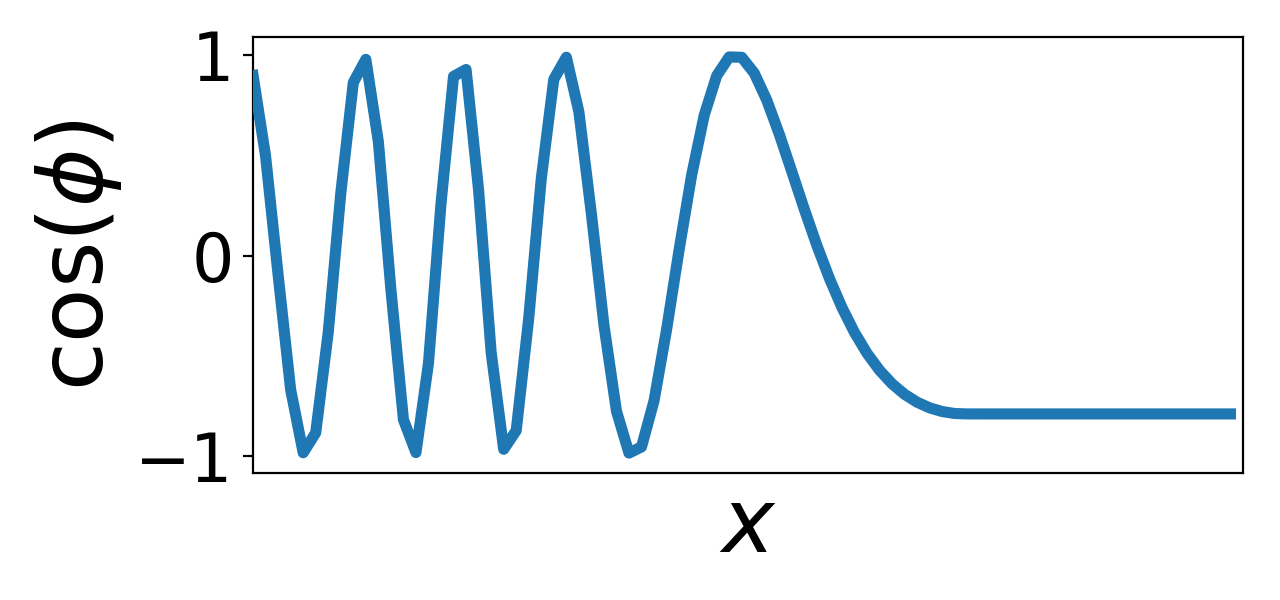

<IPython.core.display.Javascript object>


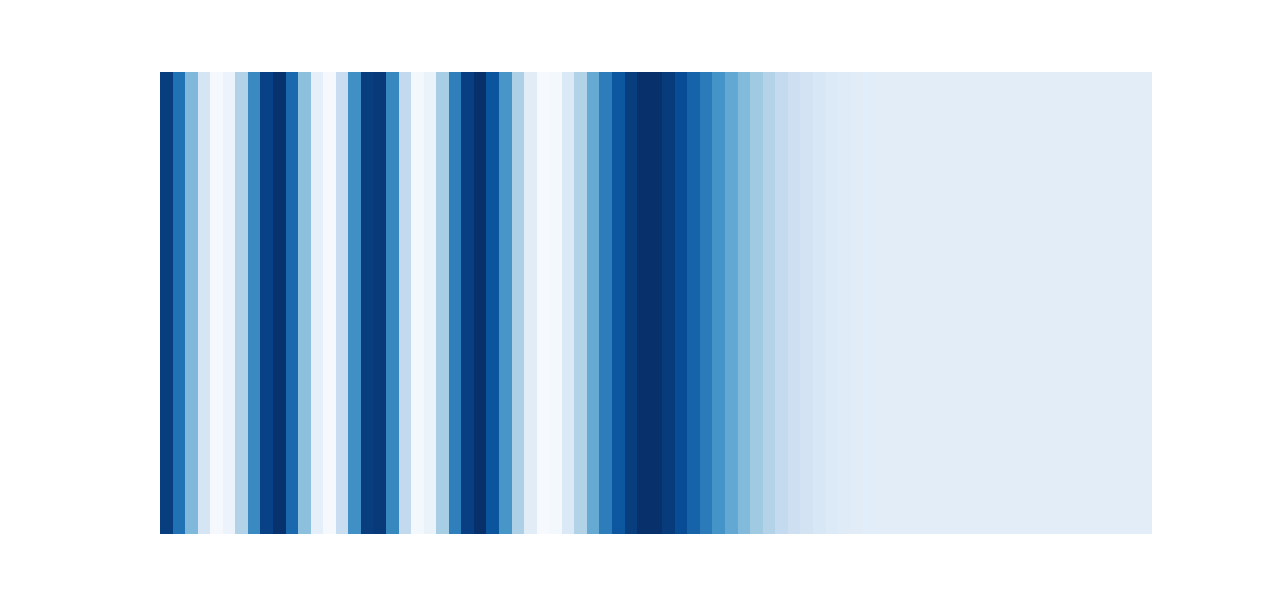

In [9]:
n_cells = param["n_cells"]
positions = np.arange(1, n_cells+1)
t_index = int(param["total_t"]/3./param["dt"])+1800
start = 20
end = 99



# 1D y profile
plt.rcParams["figure.figsize"] = 6.4, 3.
fig, ax = plt.subplots()

ax.plot(positions[start:end], np.cos(results_no_delay)[t_index,start:end], c='tab:blue', lw=4, label='cos($\phi$)', zorder=10)

# Plot options
ax.set_xlabel('$x$', fontsize=32)
ax.set_ylabel('cos($\phi$)', fontsize=32)
ax.set_xlim([positions[start], positions[end]])
ax.set_xticks([])
ax.tick_params(labelsize=24)

fig.tight_layout()
fig.show()



# 2D y profile
tissue = np.array([np.cos(results_no_delay)[t_index,start:end] for k in range(50)])
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=-1.0, vmax=1.)
ax.imshow(tissue, norm=norm, cmap='Blues', aspect='auto')  

ax.axis('off')
fig.show()

####       

**1.4.2 Short delay in the coupling**

We now consider a small delay in the coupling between neighboring cells, as in Fig. 3b) of (Morelli et al., 2009).

<IPython.core.display.Javascript object>


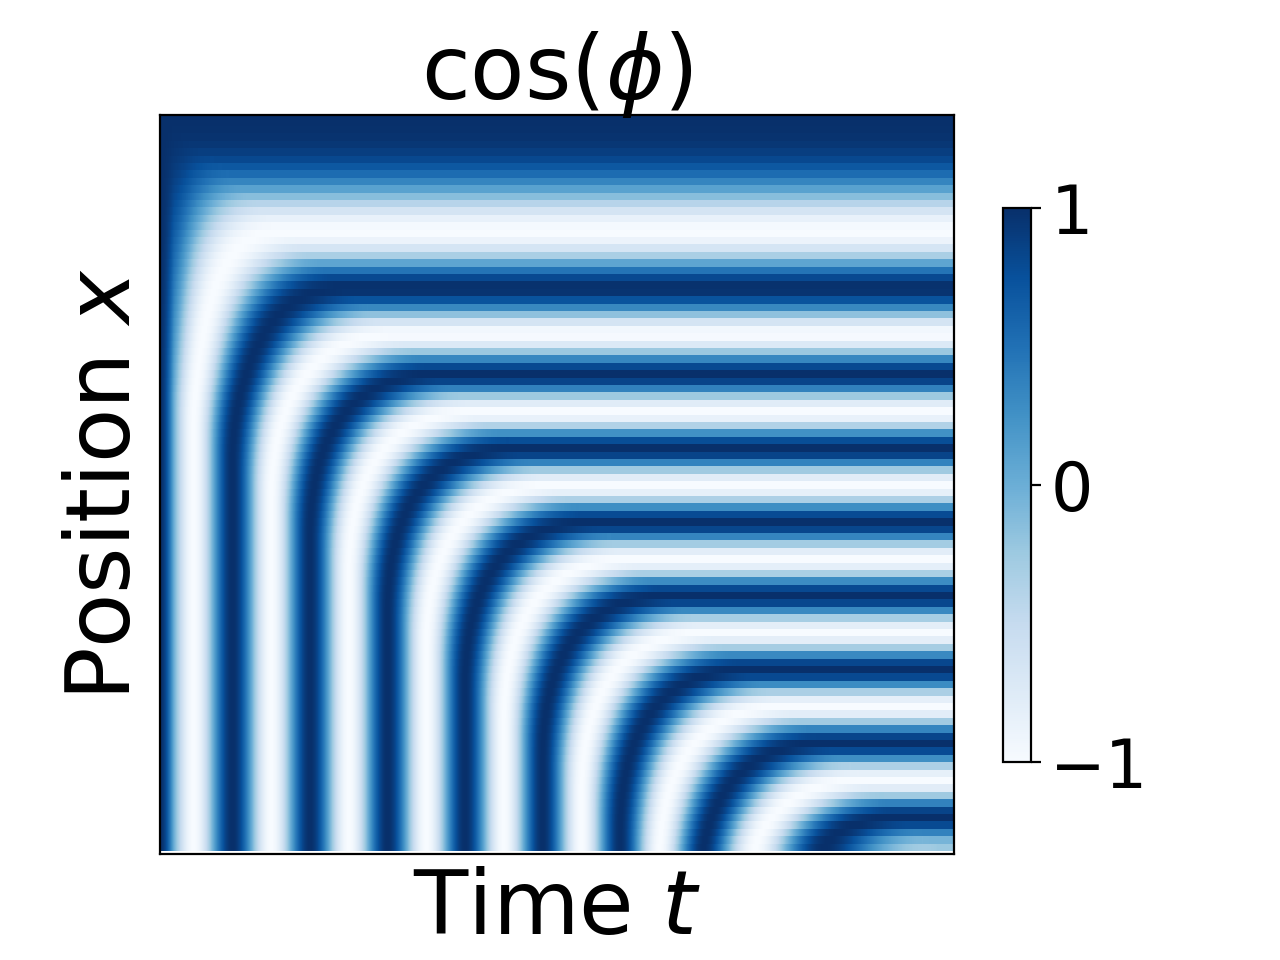

In [10]:
# Generate the results
param["tau"] = 7.
results_small_delay, omega_profile_small_delay, times = integrate(param)


# Plot a kymograph of the results
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
    
# Kymograph
norm = colors.Normalize(vmin=-1., vmax=1.)
kymo = ax.imshow(np.cos(results_small_delay).transpose(), norm=norm, cmap='Blues', aspect='auto')
   
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-1., 0., 1.])
cb.ax.tick_params(labelsize=24)
  
# Other plot options
ax.set_title('$\cos(\phi)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####       

**1.4.3 Long delay in the coupling**

We now consider a long delay in the coupling between neighboring cells, as in Fig. 3c) of (Morelli et al., 2009).

<IPython.core.display.Javascript object>


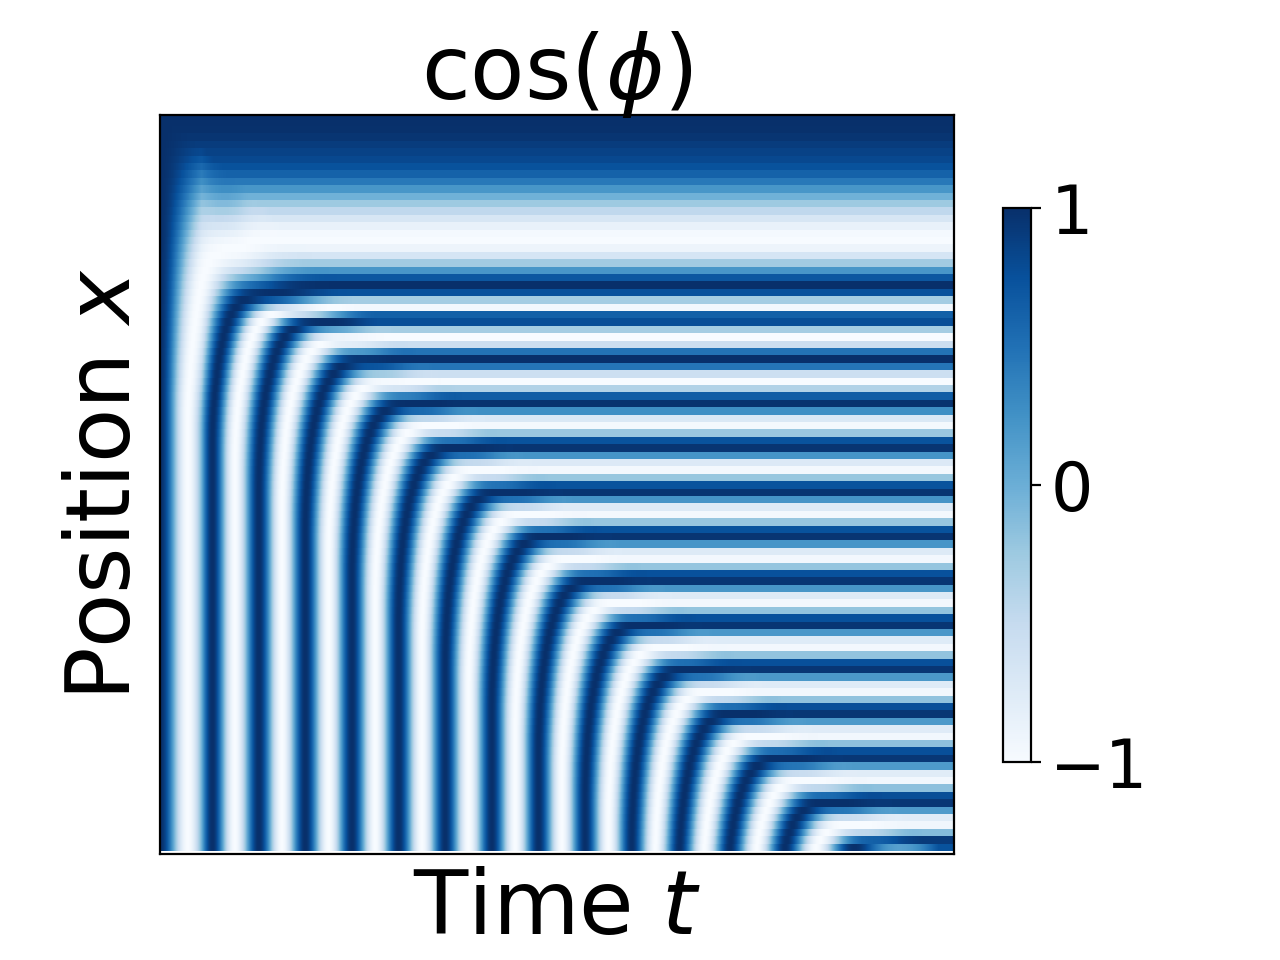

In [11]:
# Generate the results
param["tau"] = 21.
results_long_delay, omega_profile_long_delay, times = integrate(param)


# Plot a kymograph of the results
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()
   
# Kymograph
norm = colors.Normalize(vmin=-1., vmax=1.)
kymo = ax.imshow(np.cos(results_long_delay).transpose(), norm=norm, cmap='Blues', aspect='auto')
 
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-1., 0., 1.])
cb.ax.tick_params(labelsize=24)

# Other plot options
ax.set_title('$\cos(\phi)$', fontsize=32)
ax.set_xlabel('Time $t$', fontsize=32)
ax.set_ylabel('Position $x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()